In [1]:
%matplotlib widget
import os
import re
import pandas
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from lmfit import Model
import pickle

from matplotlib.widgets import SpanSelector,Button
from ipywidgets import interact, interact_manual, FloatSlider, Dropdown, SelectionRangeSlider

# Experiment 1: 0.5mM NADH

In [3]:
data_NADH1 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD1.xlsx")
#A view of the data
data_NADH1.head()

,Time_min,A2,A3,B1,B2,B3,C1,C2,C3,D1,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.910562,0.988804,0.912032,0.949007,0.938032,0.994338,0.915634,0.974595,0.829018,...,0.828256,0.858676,0.822056,0.878014,0.873818,0.837071,0.825895,0.874967,0.817981,0.860750
1,0.074467,0.912440,0.993190,0.903387,0.945750,0.919085,1.013846,0.897793,0.972695,0.824697,...,0.823174,0.860519,0.826947,0.892302,0.879679,0.840009,0.822603,0.874133,0.830503,0.877653
2,0.157950,0.913950,0.983294,0.904944,0.972279,0.955062,0.997816,0.908173,0.970093,0.821185,...,0.821709,0.857915,0.820295,0.888120,0.873514,0.834296,0.822563,0.876341,0.825720,0.868846
3,0.240917,0.911121,0.979178,0.896668,0.958759,0.964606,0.985443,0.909736,0.969646,0.818623,...,0.819065,0.852787,0.816832,0.875721,0.841955,0.835835,0.822905,0.870016,0.819997,0.877925
4,0.324483,0.908419,0.975126,0.894416,0.967044,0.948143,0.975822,0.902347,0.962771,0.814112,...,0.816769,0.853032,0.819700,0.874970,0.838276,0.830389,0.818741,0.869748,0.815626,0.900346


In [4]:
data_NADH1.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH1.columns]
data_NADH1.head()

,Time_min,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,Sample_D1,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.910562,0.988804,0.912032,0.949007,0.938032,0.994338,0.915634,0.974595,0.829018,...,0.828256,0.858676,0.822056,0.878014,0.873818,0.837071,0.825895,0.874967,0.817981,0.860750
1,0.074467,0.912440,0.993190,0.903387,0.945750,0.919085,1.013846,0.897793,0.972695,0.824697,...,0.823174,0.860519,0.826947,0.892302,0.879679,0.840009,0.822603,0.874133,0.830503,0.877653
2,0.157950,0.913950,0.983294,0.904944,0.972279,0.955062,0.997816,0.908173,0.970093,0.821185,...,0.821709,0.857915,0.820295,0.888120,0.873514,0.834296,0.822563,0.876341,0.825720,0.868846
3,0.240917,0.911121,0.979178,0.896668,0.958759,0.964606,0.985443,0.909736,0.969646,0.818623,...,0.819065,0.852787,0.816832,0.875721,0.841955,0.835835,0.822905,0.870016,0.819997,0.877925
4,0.324483,0.908419,0.975126,0.894416,0.967044,0.948143,0.975822,0.902347,0.962771,0.814112,...,0.816769,0.853032,0.819700,0.874970,0.838276,0.830389,0.818741,0.869748,0.815626,0.900346


In [5]:
samples = [s for s in data_NADH1.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH1.index,
    index=(0,40),
    description='Time_min')

In [6]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
   

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\1590133685.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\1590133685.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


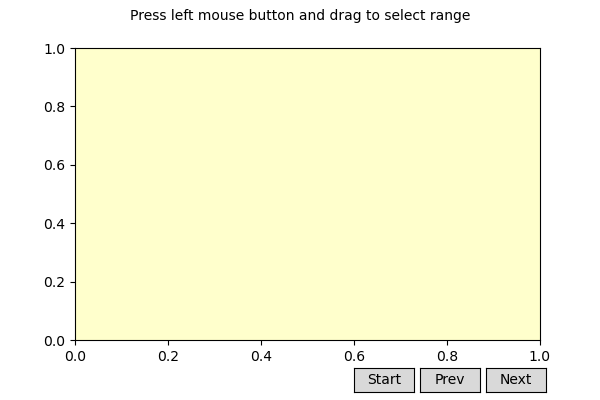

In [19]:
a=LinReg(data_NADH1)

In [20]:
slopes1 = a.make_summary()
slopes1.head()

,rate
Sample_A2,-0.039034
Sample_A3,-0.040367
Sample_B1,-0.037320
Sample_B2,-0.037879
Sample_B3,-0.034833


In [21]:
slopes1

,rate
Sample_A2,-0.039034
Sample_A3,-0.040367
Sample_B1,-0.037320
Sample_B2,-0.037879
Sample_B3,-0.034833
Sample_C1,-0.033881
Sample_C2,-0.035486
Sample_C3,-0.039541
Sample_D1,-0.035511
Sample_D2,-0.033372


In [28]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [29]:
slopes1 = slopes1 / El # umol/ml/min (mM/min)
slopes1 = slopes1 / (protein/V) # umol/min/mg prot
exp1rates = -slopes1

In [35]:
writer = pandas.ExcelWriter('output_forward1.xlsx')
exp1rates.to_excel(writer, sheet_name='exp1')
writer.save()

# Experiment 2: 0.41mM NADH

In [36]:
data_NADH2 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD2.xlsx")
#A view of the data
data_NADH2.head()

,Time_min,A4,A5,A6,B4,B5,B6,C4,C5,C6,...,D6,E4,E5,E6,F4,F5,F6,G4,G5,G6
0,0.000000,0.789543,0.807423,0.838199,0.819684,0.849709,0.867642,0.835034,0.815738,0.834756,...,0.752137,0.660624,0.567273,0.332307,0.728260,0.762293,0.784030,0.542977,0.493483,0.938762
1,0.073517,0.799117,0.812441,0.851385,0.817532,0.862867,0.910628,0.850101,0.812457,0.834957,...,0.750365,0.658174,0.573566,0.332118,0.715744,0.755989,0.797161,0.548211,0.501707,0.882938
2,0.156767,0.805892,0.809407,0.853702,0.813160,0.855456,0.902295,0.861683,0.816657,0.851459,...,0.749344,0.659483,0.575093,0.331971,0.712185,0.755436,0.791140,0.549257,0.504298,0.902440
3,0.240200,0.794409,0.803744,0.849807,0.815205,0.854002,0.886523,0.808887,0.815673,0.834288,...,0.742914,0.657047,0.570410,0.330605,0.705757,0.748788,0.798440,0.545036,0.502908,0.908694
4,0.323750,0.790691,0.802693,0.855689,0.808129,0.859248,0.896567,0.838494,0.807052,0.831846,...,0.743125,0.657400,0.572192,0.330708,0.700569,0.752875,0.798334,0.545846,0.503101,0.871191


In [37]:

data_NADH2.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH2.columns]
data_NADH2.head()

,Time_min,Sample_A4,Sample_A5,Sample_A6,Sample_B4,Sample_B5,Sample_B6,Sample_C4,Sample_C5,Sample_C6,...,Sample_D6,Sample_E4,Sample_E5,Sample_E6,Sample_F4,Sample_F5,Sample_F6,Sample_G4,Sample_G5,Sample_G6
0,0.000000,0.789543,0.807423,0.838199,0.819684,0.849709,0.867642,0.835034,0.815738,0.834756,...,0.752137,0.660624,0.567273,0.332307,0.728260,0.762293,0.784030,0.542977,0.493483,0.938762
1,0.073517,0.799117,0.812441,0.851385,0.817532,0.862867,0.910628,0.850101,0.812457,0.834957,...,0.750365,0.658174,0.573566,0.332118,0.715744,0.755989,0.797161,0.548211,0.501707,0.882938
2,0.156767,0.805892,0.809407,0.853702,0.813160,0.855456,0.902295,0.861683,0.816657,0.851459,...,0.749344,0.659483,0.575093,0.331971,0.712185,0.755436,0.791140,0.549257,0.504298,0.902440
3,0.240200,0.794409,0.803744,0.849807,0.815205,0.854002,0.886523,0.808887,0.815673,0.834288,...,0.742914,0.657047,0.570410,0.330605,0.705757,0.748788,0.798440,0.545036,0.502908,0.908694
4,0.323750,0.790691,0.802693,0.855689,0.808129,0.859248,0.896567,0.838494,0.807052,0.831846,...,0.743125,0.657400,0.572192,0.330708,0.700569,0.752875,0.798334,0.545846,0.503101,0.871191


In [38]:
samples = [s for s in data_NADH2.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH2.index,
    index=(0,40),
    description='Time [min]',
)

In [39]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
           

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3657682931.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3657682931.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


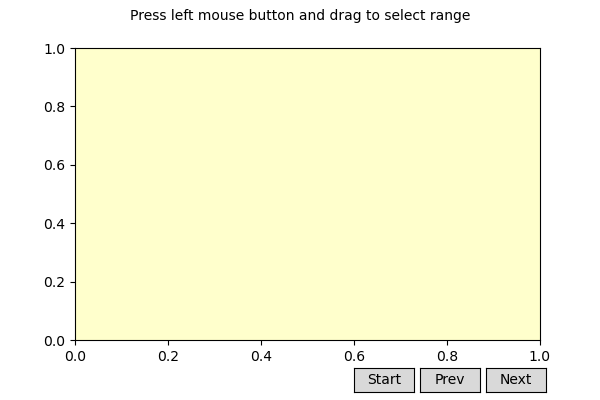

In [40]:
a=LinReg(data_NADH2)

In [41]:
slopes2 = a.make_summary()
slopes2.head()

,rate
Sample_A4,-0.035794
Sample_A5,-0.030519
Sample_A6,-0.033852
Sample_B4,-0.030270
Sample_B5,-0.030581


In [42]:
slopes2

,rate
Sample_A4,-0.035794
Sample_A5,-0.030519
Sample_A6,-0.033852
Sample_B4,-0.030270
Sample_B5,-0.030581
Sample_B6,-0.036451
Sample_C4,-0.027077
Sample_C5,-0.038086
Sample_C6,-0.035230
Sample_D4,-0.035087


In [49]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [50]:
slopes2 = slopes2 / El # umol/ml/min (mM/min)
slopes2 = slopes2 / (protein/V) # umol/min/mg prot
#slopes2_pre_complete = slopes2 / (-1) #sign change if needed 
exp2rates = -slopes2

In [55]:
writer = pandas.ExcelWriter('output_forward2.xlsx')
exp2rates.to_excel(writer, sheet_name='exp2')
writer.save()

# Experiment 3: 0.33mM NADH

In [58]:
data_NADH3 = pandas.read_excel(r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD3.xlsx")
#A view of the data
data_NADH3.head()

,Time_min,A7,A8,A9,B7,B8,B9,C7,C8,C9,...,D9,E7,E8,E9,F7,F8,F9,G7,G8,G9
0,0.000000,0.681110,0.718558,0.730318,0.783080,0.806663,0.826446,0.748083,0.705910,0.747296,...,0.669537,0.637412,0.660078,0.646338,0.709719,0.607126,0.657344,0.624032,0.641538,0.642029
1,0.076050,0.685844,0.736359,0.744354,0.782543,0.801857,0.824056,0.752212,0.704006,0.742407,...,0.669256,0.640859,0.651176,0.665684,0.705169,0.614857,0.655796,0.632370,0.643700,0.660037
2,0.159183,0.702623,0.728561,0.746897,0.784424,0.798168,0.813132,0.755000,0.703043,0.743274,...,0.669687,0.641698,0.652551,0.679271,0.706655,0.612557,0.663722,0.631945,0.651335,0.660133
3,0.242450,0.691035,0.728120,0.746098,0.782642,0.787532,0.814963,0.748780,0.699361,0.742428,...,0.665045,0.641444,0.654469,0.688137,0.692278,0.614402,0.664694,0.629962,0.642279,0.673570
4,0.325650,0.691950,0.707629,0.735934,0.778179,0.776997,0.806364,0.745683,0.698377,0.736597,...,0.666343,0.631713,0.655352,0.677334,0.713711,0.613186,0.674193,0.628621,0.641808,0.673699


In [59]:
data_NADH3.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH3.columns]
data_NADH3.head()

,Time_min,Sample_A7,Sample_A8,Sample_A9,Sample_B7,Sample_B8,Sample_B9,Sample_C7,Sample_C8,Sample_C9,...,Sample_D9,Sample_E7,Sample_E8,Sample_E9,Sample_F7,Sample_F8,Sample_F9,Sample_G7,Sample_G8,Sample_G9
0,0.000000,0.681110,0.718558,0.730318,0.783080,0.806663,0.826446,0.748083,0.705910,0.747296,...,0.669537,0.637412,0.660078,0.646338,0.709719,0.607126,0.657344,0.624032,0.641538,0.642029
1,0.076050,0.685844,0.736359,0.744354,0.782543,0.801857,0.824056,0.752212,0.704006,0.742407,...,0.669256,0.640859,0.651176,0.665684,0.705169,0.614857,0.655796,0.632370,0.643700,0.660037
2,0.159183,0.702623,0.728561,0.746897,0.784424,0.798168,0.813132,0.755000,0.703043,0.743274,...,0.669687,0.641698,0.652551,0.679271,0.706655,0.612557,0.663722,0.631945,0.651335,0.660133
3,0.242450,0.691035,0.728120,0.746098,0.782642,0.787532,0.814963,0.748780,0.699361,0.742428,...,0.665045,0.641444,0.654469,0.688137,0.692278,0.614402,0.664694,0.629962,0.642279,0.673570
4,0.325650,0.691950,0.707629,0.735934,0.778179,0.776997,0.806364,0.745683,0.698377,0.736597,...,0.666343,0.631713,0.655352,0.677334,0.713711,0.613186,0.674193,0.628621,0.641808,0.673699


In [60]:
samples = [s for s in data_NADH3.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH3.index,
    index=(0,40),
    description='Time [min]',
)

In [61]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


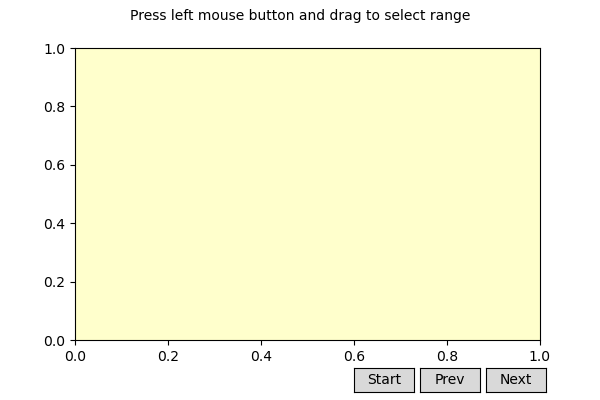

In [62]:
a=LinReg(data_NADH3)

In [63]:
slopes3 = a.make_summary()
slopes3.head()

,rate
Sample_A7,-0.036049
Sample_A8,-0.029709
Sample_A9,-0.035818
Sample_B7,-0.039848
Sample_B8,-0.024378


In [64]:
slopes3

,rate
Sample_A7,-0.036049
Sample_A8,-0.029709
Sample_A9,-0.035818
Sample_B7,-0.039848
Sample_B8,-0.024378
Sample_B9,-0.032526
Sample_C7,-0.032264
Sample_C8,-0.031492
Sample_C9,-0.036460
Sample_D7,-0.033089


In [71]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [72]:
slopes3 = slopes3 / El # umol/ml/min (mM/min)
slopes3 = slopes3 / (protein/V) # umol/min/mg prot
#slopes3_pre_complete = slopes3 / (-1) #sign change if needed 
exp3rates = -slopes3

In [78]:
writer = pandas.ExcelWriter('output_forward3.xlsx')
exp3rates.to_excel(writer, sheet_name='exp3')
writer.save()

# Experiment 4: 0.083mM NADH (at Km)

In [79]:
data_NADH4 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD4.xlsx")
#A view of the data
data_NADH4.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D2,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.408128,0.457062,0.448561,0.472453,0.461087,0.445886,0.407895,0.421639,0.419049,...,0.362988,0.342659,0.340225,0.343576,0.342757,0.326329,0.336858,0.310893,0.330541,0.324005
1,0.075850,0.406918,0.458409,0.443056,0.468137,0.456772,0.440470,0.406654,0.418111,0.415302,...,0.363803,0.343998,0.340884,0.342229,0.339024,0.325099,0.338139,0.311824,0.333620,0.325361
2,0.159100,0.416800,0.456522,0.440851,0.467543,0.457453,0.442797,0.399766,0.415859,0.412666,...,0.360450,0.344769,0.339424,0.340424,0.337269,0.325131,0.339246,0.312507,0.333332,0.324560
3,0.242300,0.417281,0.456891,0.441068,0.468583,0.454968,0.437984,0.399208,0.413594,0.409175,...,0.360218,0.342903,0.338607,0.340072,0.334446,0.324931,0.337568,0.311384,0.334212,0.325282
4,0.325717,0.422183,0.456333,0.437869,0.470819,0.456264,0.446077,0.399583,0.410381,0.406526,...,0.359439,0.339634,0.336079,0.337066,0.330926,0.324899,0.338823,0.311484,0.334862,0.325378


In [80]:
data_NADH4.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH4.columns]
data_NADH4.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D2,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.408128,0.457062,0.448561,0.472453,0.461087,0.445886,0.407895,0.421639,0.419049,...,0.362988,0.342659,0.340225,0.343576,0.342757,0.326329,0.336858,0.310893,0.330541,0.324005
1,0.075850,0.406918,0.458409,0.443056,0.468137,0.456772,0.440470,0.406654,0.418111,0.415302,...,0.363803,0.343998,0.340884,0.342229,0.339024,0.325099,0.338139,0.311824,0.333620,0.325361
2,0.159100,0.416800,0.456522,0.440851,0.467543,0.457453,0.442797,0.399766,0.415859,0.412666,...,0.360450,0.344769,0.339424,0.340424,0.337269,0.325131,0.339246,0.312507,0.333332,0.324560
3,0.242300,0.417281,0.456891,0.441068,0.468583,0.454968,0.437984,0.399208,0.413594,0.409175,...,0.360218,0.342903,0.338607,0.340072,0.334446,0.324931,0.337568,0.311384,0.334212,0.325282
4,0.325717,0.422183,0.456333,0.437869,0.470819,0.456264,0.446077,0.399583,0.410381,0.406526,...,0.359439,0.339634,0.336079,0.337066,0.330926,0.324899,0.338823,0.311484,0.334862,0.325378


In [81]:
samples = [s for s in data_NADH4.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH4.index,
    index=(0,40),
    description='Time [min]')

In [82]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


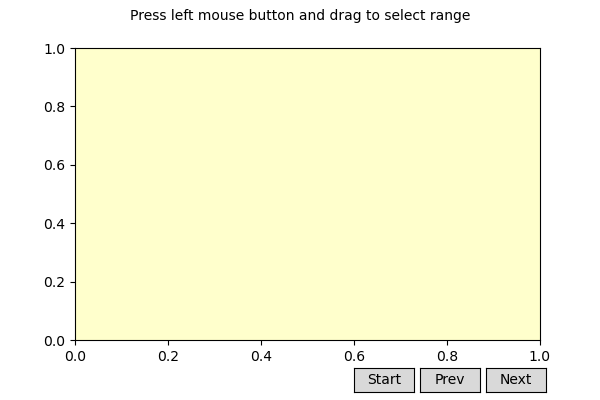

In [83]:
a=LinReg(data_NADH4)

In [84]:
slopes4 = a.make_summary()
slopes4.head()

,rate
Sample_A1,-0.023853
Sample_A2,-0.020231
Sample_A3,-0.016599
Sample_B1,-0.025549
Sample_B2,-0.018110


In [85]:
slopes4

,rate
Sample_A1,-0.023853
Sample_A2,-0.020231
Sample_A3,-0.016599
Sample_B1,-0.025549
Sample_B2,-0.018110
Sample_B3,-0.017955
Sample_C1,-0.020953
Sample_C2,-0.021343
Sample_C3,-0.020839
Sample_D1,-0.019157


In [92]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [93]:
slopes4 = slopes4 / El # umol/ml/min (mM/min)
slopes4 = slopes4 / (protein/V) # umol/min/mg prot
#frame_pre_complete = frame / (-1) #sign change if needed 
exp4rates = -slopes4

In [98]:
writer = pandas.ExcelWriter('output2virexp4.xlsx')
exp4rates.to_excel(writer, sheet_name='exp4')
writer.save()

# Experiment 5: 0.067mM NADH

In [99]:
data_NADH5 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD5.xlsx")
#A view of the data
data_NADH5.head()

,Time_min,A4,A5,A6,B4,B5,B6,C4,C5,C6,...,D6,E4,E5,E6,F4,F5,F6,G4,G5,G6
0,0.000000,0.403937,0.403912,0.402774,0.405406,0.413837,0.430127,0.386525,0.383884,0.388777,...,0.322530,0.305126,0.281402,0.351980,0.358822,0.268988,0.278356,0.272225,0.277838,0.374894
1,0.073417,0.401564,0.401313,0.400447,0.405291,0.412176,0.401708,0.377750,0.376687,0.383584,...,0.312193,0.294719,0.271981,0.360060,0.351443,0.279694,0.284801,0.276010,0.274324,0.340208
2,0.156783,0.399485,0.398196,0.399830,0.409408,0.414436,0.385857,0.384220,0.368936,0.379041,...,0.311350,0.293995,0.272605,0.324893,0.313419,0.281657,0.276904,0.274188,0.272199,0.325110
3,0.240083,0.396469,0.397581,0.399203,0.417854,0.411713,0.398650,0.373658,0.359116,0.368303,...,0.303483,0.286318,0.268928,0.304074,0.278246,0.278178,0.276856,0.277767,0.269767,0.303510
4,0.323433,0.396276,0.400595,0.398165,0.396923,0.401413,0.386112,0.360460,0.371445,0.366768,...,0.299263,0.279682,0.261527,0.302148,0.257532,0.274224,0.277610,0.279597,0.266347,0.278403


In [100]:
data_NADH5.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH5.columns]
data_NADH5.head()

,Time_min,Sample_A4,Sample_A5,Sample_A6,Sample_B4,Sample_B5,Sample_B6,Sample_C4,Sample_C5,Sample_C6,...,Sample_D6,Sample_E4,Sample_E5,Sample_E6,Sample_F4,Sample_F5,Sample_F6,Sample_G4,Sample_G5,Sample_G6
0,0.000000,0.403937,0.403912,0.402774,0.405406,0.413837,0.430127,0.386525,0.383884,0.388777,...,0.322530,0.305126,0.281402,0.351980,0.358822,0.268988,0.278356,0.272225,0.277838,0.374894
1,0.073417,0.401564,0.401313,0.400447,0.405291,0.412176,0.401708,0.377750,0.376687,0.383584,...,0.312193,0.294719,0.271981,0.360060,0.351443,0.279694,0.284801,0.276010,0.274324,0.340208
2,0.156783,0.399485,0.398196,0.399830,0.409408,0.414436,0.385857,0.384220,0.368936,0.379041,...,0.311350,0.293995,0.272605,0.324893,0.313419,0.281657,0.276904,0.274188,0.272199,0.325110
3,0.240083,0.396469,0.397581,0.399203,0.417854,0.411713,0.398650,0.373658,0.359116,0.368303,...,0.303483,0.286318,0.268928,0.304074,0.278246,0.278178,0.276856,0.277767,0.269767,0.303510
4,0.323433,0.396276,0.400595,0.398165,0.396923,0.401413,0.386112,0.360460,0.371445,0.366768,...,0.299263,0.279682,0.261527,0.302148,0.257532,0.274224,0.277610,0.279597,0.266347,0.278403


In [101]:
samples = [s for s in data_NADH5.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH5.index,
    index=(0,40),
    description='Time [min]',
)

In [102]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
        

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\2533943574.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\2533943574.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


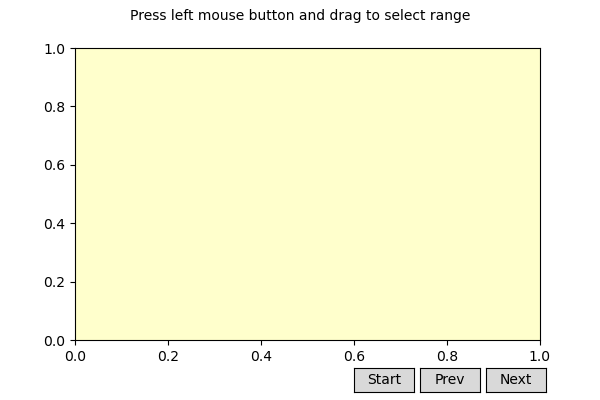

In [104]:
a=LinReg(data_NADH5)

In [105]:
slopes5 = a.make_summary()
slopes5.head()

,rate
Sample_A4,-0.013701
Sample_A5,-0.013701
Sample_A6,-0.019260
Sample_B4,-0.014876
Sample_B5,-0.026036


In [106]:
slopes5

,rate
Sample_A4,-0.013701
Sample_A5,-0.013701
Sample_A6,-0.019260
Sample_B4,-0.014876
Sample_B5,-0.026036
Sample_B6,-0.029796
Sample_C4,-0.027920
Sample_C5,-0.015228
Sample_C6,-0.015586
Sample_D4,-0.023990


In [113]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [114]:
slopes5 = slopes5 / El # umol/ml/min (mM/min)
slopes5 = slopes5 / (protein/V) # umol/min/mg prot
#slopes5_pre_complete = slopes5 / (-1) #sign change if needed 
exp5rates = -slopes5

In [118]:
writer = pandas.ExcelWriter('output3virexp5.xlsx')
exp5rates.to_excel(writer, sheet_name='exp5')
writer.save()

# Experiment 6: 0.05mM NADH

In [119]:
data_NADH6 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD6.xlsx")
#A view of the data
data_NADH6.head()

,Time_min,A1,A2,A3,B1,B2,B3,C1,C2,C3,...,D3,E1,E2,E3,F1,F2,F3,G1,G2,G3
0,0.000000,0.374640,0.372764,0.372991,0.373578,0.371525,0.446022,0.418706,0.325704,0.320205,...,0.264015,0.232053,0.237958,0.295843,0.374364,0.210858,0.236177,0.212956,0.236674,0.259614
1,0.079750,0.371870,0.3705,0.372219,0.370322,0.371362,0.403638,0.401482,0.329077,0.324426,...,0.260664,0.234123,0.236994,0.305943,0.360136,0.217311,0.223839,0.213714,0.235101,0.283448
2,0.163350,0.369902,0.369557,0.371417,0.368110,0.371085,0.399344,0.412588,0.317342,0.316848,...,0.256442,0.231536,0.235071,0.319925,0.349643,0.219303,0.220192,0.215005,0.236670,0.292692
3,0.246483,0.368982,0.369459,0.369549,0.366437,0.366370,0.397339,0.408689,0.308615,0.323082,...,0.256670,0.232288,0.235838,0.308591,0.351138,0.214165,0.220413,0.218746,0.234027,0.292727
4,0.329917,0.369662,0.367876,0.367692,0.365184,0.368692,0.390727,0.389556,0.313677,0.319987,...,0.254529,0.230381,0.232966,0.302893,0.357905,0.218036,0.219519,0.217017,0.231226,0.279281


In [120]:
data_NADH6.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH6.columns]
data_NADH6.head()

,Time_min,Sample_A1,Sample_A2,Sample_A3,Sample_B1,Sample_B2,Sample_B3,Sample_C1,Sample_C2,Sample_C3,...,Sample_D3,Sample_E1,Sample_E2,Sample_E3,Sample_F1,Sample_F2,Sample_F3,Sample_G1,Sample_G2,Sample_G3
0,0.000000,0.374640,0.372764,0.372991,0.373578,0.371525,0.446022,0.418706,0.325704,0.320205,...,0.264015,0.232053,0.237958,0.295843,0.374364,0.210858,0.236177,0.212956,0.236674,0.259614
1,0.079750,0.371870,0.3705,0.372219,0.370322,0.371362,0.403638,0.401482,0.329077,0.324426,...,0.260664,0.234123,0.236994,0.305943,0.360136,0.217311,0.223839,0.213714,0.235101,0.283448
2,0.163350,0.369902,0.369557,0.371417,0.368110,0.371085,0.399344,0.412588,0.317342,0.316848,...,0.256442,0.231536,0.235071,0.319925,0.349643,0.219303,0.220192,0.215005,0.236670,0.292692
3,0.246483,0.368982,0.369459,0.369549,0.366437,0.366370,0.397339,0.408689,0.308615,0.323082,...,0.256670,0.232288,0.235838,0.308591,0.351138,0.214165,0.220413,0.218746,0.234027,0.292727
4,0.329917,0.369662,0.367876,0.367692,0.365184,0.368692,0.390727,0.389556,0.313677,0.319987,...,0.254529,0.230381,0.232966,0.302893,0.357905,0.218036,0.219519,0.217017,0.231226,0.279281


In [121]:
samples = [s for s in data_NADH6.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH6.index,
    index=(0,40),
    description='Time [min]',
)

In [122]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
        

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\2533943574.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\2533943574.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


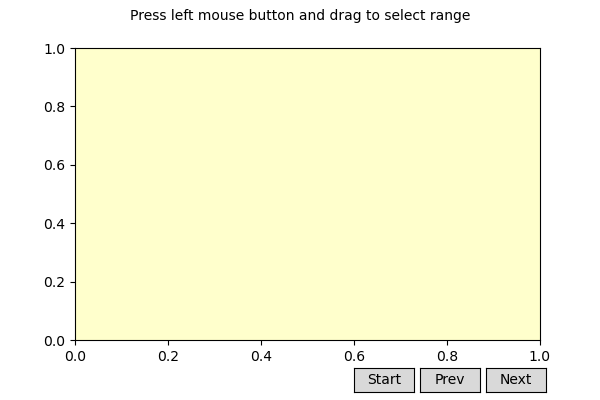

In [123]:
a=LinReg(data_NADH6)

In [124]:
slopes6 = a.make_summary()
slopes6.head()

,rate
Sample_A1,-0.007004
Sample_A2,-0.007004
Sample_A3,-0.009171
Sample_B1,-0.020261
Sample_B2,-0.006867


In [125]:
slopes6

,rate
Sample_A1,-0.007004
Sample_A2,-0.007004
Sample_A3,-0.009171
Sample_B1,-0.020261
Sample_B2,-0.006867
Sample_B3,-0.024547
Sample_C1,-0.094785
Sample_C2,-0.014723
Sample_C3,-0.013855
Sample_D1,-0.006943


In [132]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [133]:
slopes6 = slopes6 / El # umol/ml/min (mM/min)
slopes6 = slopes6 / (protein/V) # umol/min/mg prot
#slopes6_pre_complete = slopes6 / (-1) #sign change if needed 
exp6rates = -slopes6

In [137]:
writer = pandas.ExcelWriter('output4virexp6.xlsx')
exp6rates.to_excel(writer, sheet_name='exp6')
writer.save()

# Experiment 7: 0.042mM NADH

In [138]:
data_NADH7 = pandas.read_excel (r"C:\Users\Francel\Hons project\LDH assay - TECAN (pH=7)\NAD7.xlsx")
#A view of the data
data_NADH7.head()

,Time_min,A7,A8,A9,B7,B8,B9,C7,C8,C9,...,D9,E7,E8,E9,F7,F8,F9,G7,G8,G9
0,0.000000,0.383977,0.395586,0.407018,0.388811,0.383152,0.376859,0.437989,0.342792,0.345349,...,0.275716,0.254121,0.256626,0.248185,0.277935,0.237034,0.244814,0.239853,0.236063,0.237420
1,0.075683,0.387216,0.392364,0.402187,0.382066,0.388851,0.369787,0.397840,0.337923,0.346726,...,0.275811,0.265064,0.261369,0.246691,0.280423,0.240793,0.246278,0.249541,0.235415,0.239162
2,0.158917,0.389216,0.387955,0.398669,0.380097,0.381575,0.364241,0.419056,0.339967,0.338838,...,0.271807,0.267298,0.263418,0.245466,0.283465,0.241429,0.247264,0.241945,0.238176,0.238228
3,0.242483,0.383121,0.392911,0.402186,0.383821,0.386710,0.363635,0.419925,0.332778,0.343046,...,0.276928,0.267058,0.270116,0.247256,0.275519,0.241827,0.244217,0.249951,0.240156,0.240220
4,0.325967,0.386265,0.390962,0.400311,0.385059,0.377350,0.358578,0.403382,0.332617,0.339542,...,0.271170,0.264023,0.267273,0.241694,0.272177,0.245432,0.244960,0.242155,0.237815,0.235229


In [139]:
data_NADH7.columns = [str(col) if str(col).startswith('Time') else 'Sample_' + str(col) \
                for col in data_NADH7.columns]
data_NADH7.head()

,Time_min,Sample_A7,Sample_A8,Sample_A9,Sample_B7,Sample_B8,Sample_B9,Sample_C7,Sample_C8,Sample_C9,...,Sample_D9,Sample_E7,Sample_E8,Sample_E9,Sample_F7,Sample_F8,Sample_F9,Sample_G7,Sample_G8,Sample_G9
0,0.000000,0.383977,0.395586,0.407018,0.388811,0.383152,0.376859,0.437989,0.342792,0.345349,...,0.275716,0.254121,0.256626,0.248185,0.277935,0.237034,0.244814,0.239853,0.236063,0.237420
1,0.075683,0.387216,0.392364,0.402187,0.382066,0.388851,0.369787,0.397840,0.337923,0.346726,...,0.275811,0.265064,0.261369,0.246691,0.280423,0.240793,0.246278,0.249541,0.235415,0.239162
2,0.158917,0.389216,0.387955,0.398669,0.380097,0.381575,0.364241,0.419056,0.339967,0.338838,...,0.271807,0.267298,0.263418,0.245466,0.283465,0.241429,0.247264,0.241945,0.238176,0.238228
3,0.242483,0.383121,0.392911,0.402186,0.383821,0.386710,0.363635,0.419925,0.332778,0.343046,...,0.276928,0.267058,0.270116,0.247256,0.275519,0.241827,0.244217,0.249951,0.240156,0.240220
4,0.325967,0.386265,0.390962,0.400311,0.385059,0.377350,0.358578,0.403382,0.332617,0.339542,...,0.271170,0.264023,0.267273,0.241694,0.272177,0.245432,0.244960,0.242155,0.237815,0.235229


In [140]:
samples = [s for s in data_NADH7.columns if s.startswith('Sample')]

dropdowns = [] 

for i in range(1, 3+1):

    dropdown = Dropdown(
        options=samples,
        description='Sample %d:' % i,
        disabled=False,
        value=samples[(i-1)*9]
    )
    dropdowns.append(dropdown)

srs = SelectionRangeSlider(
    options=data_NADH7.index,
    index=(0,40),
    description='Time [min]',
)

In [141]:
class LinReg(object):
    i = None
    slope = None
    keep_values = {}
    
    def __init__(self, df):
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        self.ax.set(facecolor='#FFFFCC')
        self.fig.subplots_adjust(bottom=0.15, top=0.88)
        self.axprev = plt.axes([0.7, 0.02, 0.1, 0.06])
        self.axnext = plt.axes([0.81, 0.02, 0.1, 0.06])
        self.axstart = plt.axes([0.59, 0.02, 0.1, 0.06])
        self.fig.text(0.5, 0.95, 'Press left mouse button and drag to select range', ha='center')

        self.bnext = Button(self.axnext, 'Next')
        self.bnext.on_clicked(self.nextsample)
        self.bprev = Button(self.axprev, 'Prev')
        self.bprev.on_clicked(self.prevsample)
        self.bstart = Button(self.axstart, 'Start')
        self.bstart.on_clicked(self.startsample)
        
        self.df = df
        self.samples = [i for i in list(self.df.columns) if i.startswith('Sample')]
        self.checkpath()
        self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
                    rectprops=dict(alpha=0.2, facecolor='red'))
    
    def nextsample(self, event):
        if self.i is None:
            pass
        elif self.i == len(self.samples)-1:
            self.savefig()
            self.storedata()
        else:            
            self.savefig()
            self.storedata()
            self.i += 1
            self.replot()

    def prevsample(self, event):
        if self.i == 0 or self.i is None:
            pass
        else:            
            self.savefig()
            self.storedata()
            self.i -= 1
            self.replot()
    
    def startsample(self, event):
        if self.i is not None:
            pass
        else:
            self.i = 0
            x = self.df.Time_min
            y = getattr(self.df, self.samples[self.i])
            lr = sp.stats.linregress(x, y)
            m = lr.slope
            c = lr.intercept
            r = lr.rvalue
            self.slope = m
            self.line1, = self.ax.plot(x, y, 'bo')
            self.line2, = self.ax.plot(x, m*x+c, 'g-')
            self.text1 = self.ax.text(0.03, 0.93, 'slope=%0.5f'%m, transform=self.ax.transAxes)
            self.text2 = self.ax.text(0.03, 0.87, r'$R^2$=%0.3f'%r**2, transform=self.ax.transAxes)
            self.ax.set_title(self.samples[self.i])

    def replot(self):
        x = self.df.Time_min
        y = getattr(self.df, self.samples[self.i])
        spandata = self.span.rect.get_bbox().get_points()
        xmin = spandata[0,0]
        xmax = spandata[1,0]
        if xmin == 0 and xmax == 0:
            thisx = x
            thisy = y
        else:
            indmin, indmax = np.searchsorted(x, (xmin, xmax))
            indmax = min(len(x) - 1, indmax)
            thisx = x.iloc[indmin:indmax]
            thisy = y.iloc[indmin:indmax]
        lr = sp.stats.linregress(x=thisx, y=thisy)
        m = lr.slope
        c = lr.intercept
        r = lr.rvalue
        self.slope = m
        self.line1.set_data(x, y)
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.ax.set_title(self.samples[self.i])
        self.ax.relim()
        self.ax.autoscale_view()
        self.fig.canvas.draw()
    
    def storedata(self):
        key = self.samples[self.i]
        self.keep_values[key] = self.slope
        
    def checkpath(self):
        if not os.path.isdir(os.path.join(os.curdir, 'out')):
            os.makedirs(os.path.join(os.curdir, 'out'))
        self.outpath = os.path.join(os.curdir, 'out')
    
    def savefig(self):
        outfile = self.samples[self.i]+'.png'
        self.fig.savefig(os.path.join(self.outpath, outfile), dpi=100)
        
    def onselect(self, xmin, xmax):
        x, y = self.line1.get_data()
        indmin, indmax = np.searchsorted(x, (xmin, xmax))
        indmax = min(len(x) - 1, indmax)
        thisx = x[indmin:indmax]
        thisy = y[indmin:indmax]
        m, c, r, p, err = sp.stats.linregress(x=thisx, y=thisy)
        self.slope = m
        self.line2.set_data(x, m*x+c)
        self.text1.set_text('slope=%0.5f'%m)
        self.text2.set_text(r'$R^2$=%0.3f'%r**2)
        self.fig.canvas.draw()
    
    def make_summary(self):
        return pandas.DataFrame.from_dict(self.keep_values, orient='index', columns=['rate'])
    
    def write_excel(self, filename):
        sdf = self.make_summary()
        sdf.to_excel('./out/'+filename)
        
    def zip_data(self, dirname):
        os.rename('out', dirname)
        with ZipFile(dirname+'.zip', 'w', compression=ZIP_DEFLATED) as myzip:
            for root, dirs, files in os.walk(dirname):
                for f in files:
                    myzip.write(os.path.join(root, f))
        
            

C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3951225347.py:25: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,
C:\Users\Francel\AppData\Local\Temp\ipykernel_11128\3951225347.py:25: MatplotlibDeprecationWarning: The 'span_stays' parameter of __init__() has been renamed 'interactive' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  self.span = SpanSelector(self.ax, self.onselect, 'horizontal', useblit=True, span_stays=True,


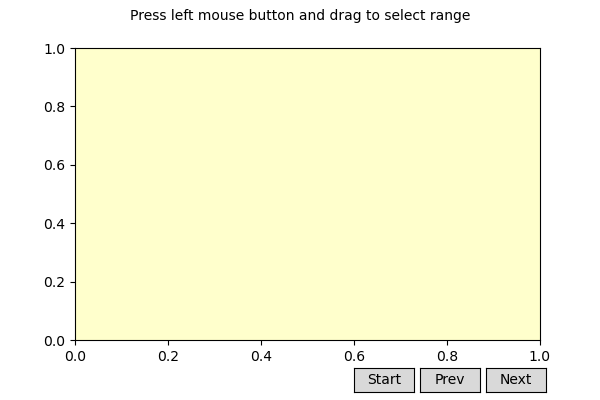

In [142]:
a=LinReg(data_NADH7)

In [182]:
slopes7 = a.make_summary()
slopes7.head()

,rate
Sample_A7,-0.007652
Sample_A8,-0.007652
Sample_A9,-0.009638
Sample_B7,-0.009343
Sample_B8,-0.005913


In [183]:
slopes7

,rate
Sample_A7,-0.007652
Sample_A8,-0.007652
Sample_A9,-0.009638
Sample_B7,-0.009343
Sample_B8,-0.005913
Sample_B9,-0.006675
Sample_C7,-0.005426
Sample_C8,-0.005792
Sample_C9,-0.006770
Sample_D7,-0.005962


In [190]:
E = 6.22 # millimolar extinction coefficient of NADH
l = 3.0419 # path lenght of light in mm
El = E*l/10 # El, convert mm to cm
V =  0.100/0.010 # Vtotal/Vsample
protein = 1.84 # mg/ml protein in sample (lysate)

In [191]:
slopes7 = slopes7 / El # umol/ml/min (mM/min)
slopes7 = slopes7 / (protein/V) # umol/min/mg prot
#slopes7_pre_complete = slopes7 / (-1) #sign change if needed 
exp7rates = -slopes7

In [194]:
writer = pandas.ExcelWriter('output6for exp7.xlsx')
exp7rates.to_excel(writer, sheet_name='exp7')
writer.save()